In [1]:
import sys
sys.path.append("/Users/shamanthk/Documents/iomics/dowhy-preeclampsia")

In [2]:
from sklearn.feature_selection import mutual_info_regression
import pandas as pd
import numpy as np
from util import *
from EstimateEffect import *

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


In [3]:
betas_df = pd.read_csv('data/betas.csv')
pds_df = pd.read_csv('data/pds.csv')

df = preproc(betas_df, pds_df)

df.head()

,Group,A1BG,A2BP1,A2ML1,A4GALT,A4GNT,AADAT,AAK1,AANAT,AARS,...,ZSCAN16,ZSCAN18,ZSCAN2,ZSCAN22,ZUFSP,ZW10,ZWINT,ZYX,ZZEF1,ZZZ3
0,0,0.348367,0.319899,0.768433,0.081964,0.685641,0.060380,0.030600,0.628545,0.034695,...,0.155679,0.065414,0.059830,0.019980,0.035917,0.080395,0.079731,0.084788,0.154323,0.054018
1,0,0.364492,0.310907,0.764368,0.070794,0.692982,0.049903,0.030167,0.623489,0.039860,...,0.119980,0.059075,0.058748,0.017119,0.034855,0.067926,0.066641,0.068883,0.139299,0.043898
2,0,0.349403,0.305689,0.771950,0.070062,0.694961,0.054181,0.029743,0.626342,0.036626,...,0.124261,0.061837,0.057167,0.018410,0.037608,0.076475,0.077044,0.077043,0.143271,0.048421
3,0,0.371034,0.303553,0.779977,0.063303,0.698230,0.048508,0.025756,0.628486,0.035684,...,0.129721,0.056181,0.052445,0.015951,0.035129,0.068537,0.069168,0.068694,0.127377,0.045447
4,0,0.374402,0.284613,0.786321,0.059106,0.697250,0.046840,0.029264,0.632338,0.033920,...,0.121801,0.054721,0.050782,0.016837,0.036205,0.062236,0.062481,0.063668,0.121910,0.041457


In [4]:
df.shape

In [5]:
X = df.drop(columns=['Group'])
y = df['Group']

In [6]:
treatment_feature = 'CACNA1S'
treatment = X[treatment_feature]
X_without_treatment = X.drop(columns=[treatment_feature])
mi_with_treatment = mutual_info_regression(X_without_treatment, treatment, random_state=42)

In [7]:
mi_with_target = mutual_info_regression(X_without_treatment, y, random_state=42)

In [8]:
mi_treatment_df = pd.DataFrame({
    'Feature': X_without_treatment.columns,
    'MI with Treatment': mi_with_treatment
})
mi_target_df = pd.DataFrame({
    'Feature': X_without_treatment.columns,
    'MI with Target': mi_with_target
})

In [9]:
top_features_treatment = mi_treatment_df.sort_values(by='MI with Treatment', ascending=False).head(5)['Feature'].tolist()
top_features_target = mi_target_df.sort_values(by='MI with Target', ascending=False).head(5)['Feature'].tolist()

In [10]:
selected_features = list(set(top_features_treatment + top_features_target))  # Remove duplicates
if treatment_feature not in selected_features:
    selected_features.append(treatment_feature)

print(f"Selected features: {selected_features}")

Selected features: ['PUM2', 'YPEL4', 'PTPN6', 'KRT24', 'NHLH1', 'GNB3', 'CMTM5', 'C3orf22', 'C11orf9', 'PAPPA2', 'CACNA1S']


In [11]:
keep_cols = selected_features + ['Group']
causal_discovery_data = df.loc[:, keep_cols]

In [12]:
causal_discovery_data.shape

In [13]:
import ipympl
%matplotlib widget

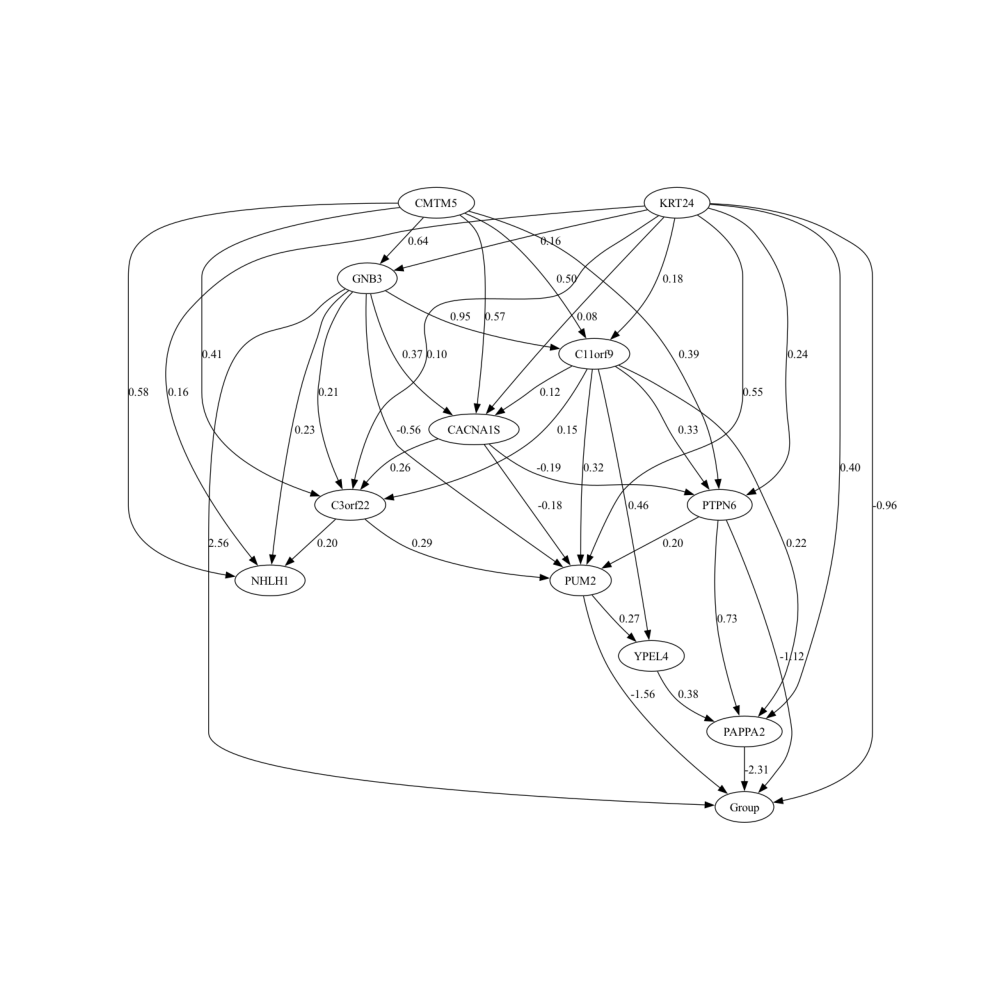

In [14]:
EstimationModel = EstimateEffect(causal_discovery_data)

causal_graph = EstimationModel.find_causal_graph(algo='icalingam')

disp_graph_nx(causal_graph)

Test permutations of given graph: 100%|██████████| 100/100 [00:41<00:00,  2.38it/s]


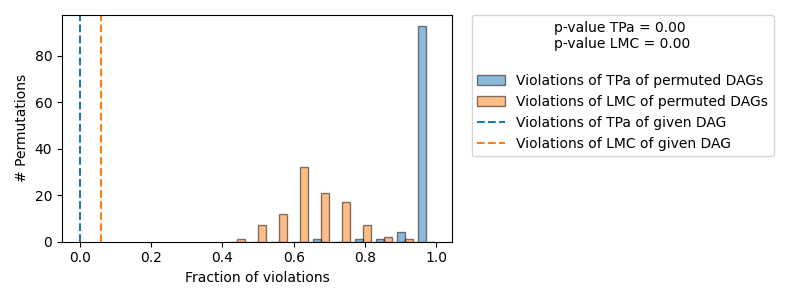

In [21]:
EstimationModel.refute_cgm(show_plt=True, n_perm=100)

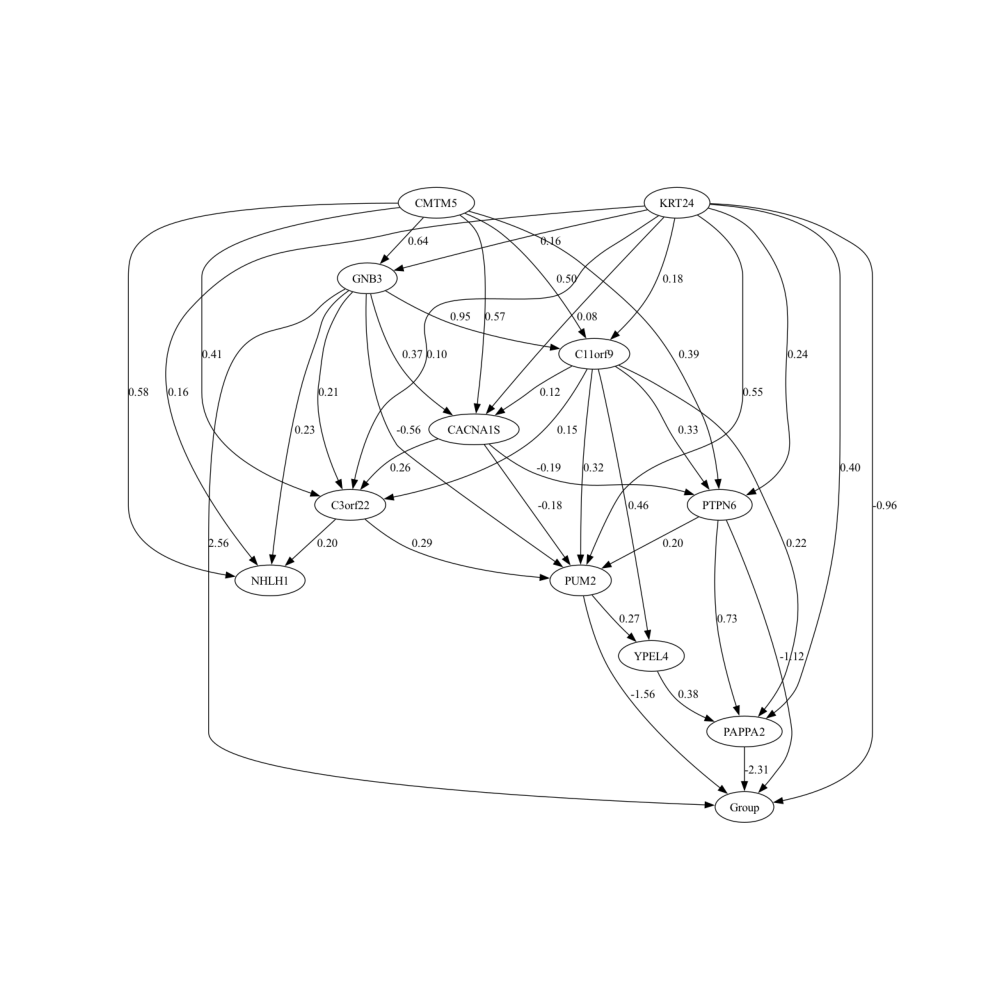

In [23]:
disp_graph_nx(causal_graph)

Test permutations of given graph: 100%|██████████| 100/100 [00:42<00:00,  2.35it/s]


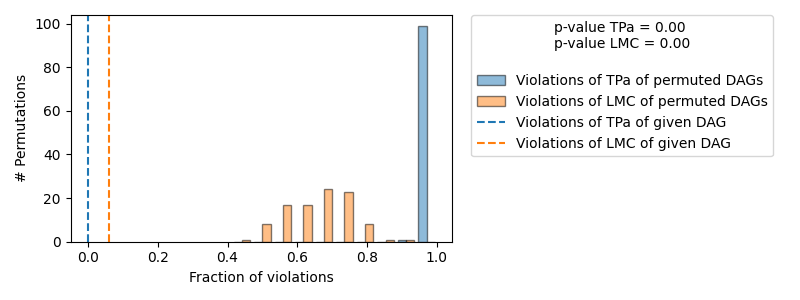

In [38]:
EstimationModel.refute_cgm(show_plt=True, n_perm=100)

In [24]:
EstimationModel.create_model(treatment='CACNA1S', outcome='Group')

In [25]:
print(EstimationModel.identify_effect())

Note that you can also use other methods for the identification process. Below are method descriptions taken directly from DoWhy's documentation
maximal-adjustment: returns the maximal set that satisfies the backdoor criterion. This is usually the fastest way to find a valid backdoor set, but the set may contain many superfluous variables.
minimal-adjustment: returns the set with minimal number of variables that satisfies the backdoor criterion. This may take longer to execute, and sometimes may not return any backdoor set within the maximum number of iterations.
exhaustive-search: returns all valid backdoor sets. This can take a while to run for large graphs.
default: This is a good mix of minimal and maximal adjustment. It starts with maximal adjustment which is usually fast. It then runs minimal adjustment and returns the set having the smallest number of variables.
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d    

In [26]:
import warnings
warnings.filterwarnings('ignore')

In [27]:
EstimationModel.estimate_effect(ctrl_val=causal_discovery_data['CACNA1S'].min(), trtm_val=causal_discovery_data['CACNA1S'].max())

Note that it is ok for your treatment to be a continuous variable, DoWhy automatically discretizes at the backend.


In [29]:
print(info['effect_estimate'].interpret())

Increasing the treatment variable(s) [CACNA1S] from 0.427734630642544 to 0.628329887613756 causes an increase of 0.17205312736289713 in the expected value of the outcome [['Group']], over the data distribution/population represented by the dataset.
None


In [32]:
EstimationModel.refute_estimate(placebo_type="permute")

In [33]:
info = EstimationModel.get_all_information()

In [34]:
print(info['graph_refutation_res'])

+-------------------------------------------------------------------------------------------------------+
|                                         Falsificaton Summary                                          |
+-------------------------------------------------------------------------------------------------------+
| The given DAG is informative because 0 / 100 of the permutations lie in the Markov                    |
| equivalence class of the given DAG (p-value: 0.00).                                                   |
| The given DAG violates 2/34 LMCs and is better than 100.0% of the permuted DAGs (p-value: 0.00).      |
| Based on the provided significance level (0.05) and because the DAG is informative,                   |
| we do not reject the DAG.                                                                             |
+-------------------------------------------------------------------------------------------------------+


In [35]:
print(info['estimand_expression'])

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                                        
──────────(E[Group|KRT24,CMTM5,C11orf9,GNB3])
d[CACNA1S]                                   
Estimand assumption 1, Unconfoundedness: If U→{CACNA1S} and U→Group then P(Group|CACNA1S,KRT24,CMTM5,C11orf9,GNB3,U) = P(Group|CACNA1S,KRT24,CMTM5,C11orf9,GNB3)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [36]:
print(info['effect_estimate'].interpret())

Increasing the treatment variable(s) [CACNA1S] from 0.427734630642544 to 0.628329887613756 causes an increase of 0.17205312736289713 in the expected value of the outcome [['Group']], over the data distribution/population represented by the dataset.
None


In [37]:
print(info['estimate_refutation_res'])

Refute: Use a Placebo Treatment
Estimated effect:0.17205312736289713
New effect:0.010818327230564487
p value:0.9199999999999999

